# Hyperparameter Optimization


## Introducción

En el desarrollo de modelos de aprendizaje automático, la elección adecuada de hiperparámetros puede marcar una gran diferencia en el desempeño final del modelo. A diferencia de los parámetros que el modelo aprende directamente de los datos, los hiperparámetros son establecidos por el desarrollador y controlan aspectos clave del proceso de entrenamiento. Encontrar la mejor combinación de estos hiperparámetros representa un desafío central en la construcción de modelos eficientes y precisos.

Contenidos

- Búsqueda Exhaustiva (Grid Search)  
- Búsqueda Aleatoria (Random Search)  
- Búsqueda Bayesiana  
- Metaheurísticas (como algoritmos genéticos o de enjambre)

## Instalación de librerías necesarias



Para poder realizar las diferentes técnicas de optimización de hiperparámetros que veremos en este taller, necesitaremos algunas bibliotecas adicionales que no están incluidas por defecto en Google Colab. A continuación, instalaremos:

- `optuna`: para realizar búsqueda bayesiana eficiente.
- `pyswarms`: para utilizar el algoritmo de optimización por enjambre de partículas (PSO).
- `deap`: para implementar algoritmos evolutivos como los genéticos.
- `scikit-optimize`: otra opción para búsqueda bayesiana.

Ejecuta la siguiente celda para instalar todas las dependencias necesarias:


In [ ]:
%%capture
!pip install optuna
!pip install pyswarms
!pip install deap
!pip install scikit-optimize

In [ ]:
# Manipulación de datos y visualización
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# División de datos y preprocesamiento
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Modelos de clasificación
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Métricas y evaluación
from sklearn.metrics import f1_score, make_scorer

# Búsqueda clásica de hiperparámetros
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Búsqueda bayesiana con scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real

# Búsqueda bayesiana con Optuna
import optuna
from optuna.samplers import TPESampler

# Algoritmos evolutivos
from deap import base, creator, tools, algorithms
import random

# Optimización por enjambre de partículas
import pyswarms as ps


In [ ]:
def evaluate_optimized_model(fitted_model, X_test, y_test):
    return f1_score(y_test, fitted_model.predict(X_test), average='weighted')

## Conjunto de datos: Predicción de la calidad del vino



Para los ejemplos prácticos de esta libreta, utilizaremos un conjunto de datos clásico en el aprendizaje automático: el conjunto de datos de **calidad del vino**. Este dataset contiene información obtenida a partir de análisis fisicoquímicos de diferentes muestras de vino, así como una evaluación sensorial de su calidad.

El objetivo será construir modelos que predigan la **calidad del vino** (una variable categórica) a partir de sus propiedades químicas.

A continuación, se describen las variables que conforman el conjunto de datos:

In [ ]:
data = pd.read_csv('/winequality.csv')
data.head(5)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Variables de entrada (características fisicoquímicas y tipo de vino):

1. **Fixed acidity** – Acidez fija  
2. **Volatile acidity** – Acidez volátil  
3. **Citric acid** – Ácido cítrico  
4. **Residual sugar** – Azúcar residual  
5. **Chlorides** – Cloruros  
6. **Free sulfur dioxide** – Dióxido de azufre libre  
7. **Total sulfur dioxide** – Dióxido de azufre total  
8. **Density** – Densidad  
9. **pH**  
10. **Sulphates** – Sulfatos  
11. **Alcohol** – Contenido alcohólico  
12. **Type** – Tipo de vino:  
    - `"red"` para vino tinto  
    - `"white"` para vino blanco

### Variable de salida:

13. **Quality** – Puntaje de calidad del vino en una escala de 0 a 10 (entero), obtenido mediante evaluación sensorial.

Este conjunto de datos permite construir modelos que predicen la calidad del vino en función de sus características fisicoquímicas y el tipo de vino.

In [ ]:
type_mapping = {'white': 0, 'red': 1}
data['type'] = data['type'].map(type_mapping)
data = data.dropna() # Eliminamos filas con valores faltantes

En este paso, convertimos la variable categórica **"type"** (que indica si el vino es blanco o tinto) en una representación numérica. Esto es necesario para que los modelos de Machine Learning puedan procesar esta variable de manera adecuada, ya que muchos modelos requieren datos numéricos como entrada.

Utilizamos un diccionario de mapeo, donde:

- `"white"` se mapea a `0`  
- `"red"` se mapea a `1`


### Visualización: Distribución de las calificaciones de calidad del vino

En esta celda, vamos a visualizar la distribución de la variable **"Quality"**, que representa las calificaciones de calidad del vino. Este gráfico de barras nos ayudará a comprender cómo se distribuyen las calificaciones en el conjunto de datos y si existen más vinos con ciertas calificaciones que con otras.

Usaremos un gráfico de barras con anotaciones para mostrar el número exacto de vinos en cada categoría de calidad.


2025-04-10 20:54:13,818 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-10 20:54:13,880 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


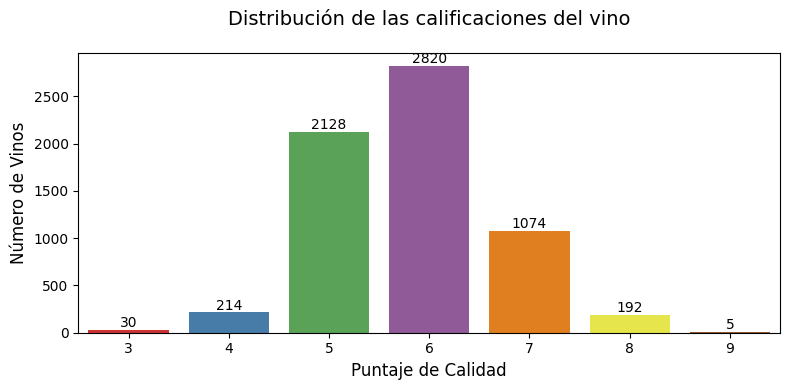

In [ ]:
# Asegurarse de que 'quality' sea un tipo de dato categórico
data['quality'] = data['quality'].astype('category')

# Crear el gráfico con una paleta diferente y corregir la advertencia
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='quality', data=data, palette='Set1', hue='quality', legend=False)

# Personalizar el gráfico
plt.title('Distribución de las calificaciones del vino', fontsize=14, pad=20)
plt.xlabel('Puntaje de Calidad', fontsize=12)
plt.ylabel('Número de Vinos', fontsize=12)

# Agregar etiquetas de conteo sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5), textcoords='offset points',
                fontsize=10, color='black')

# Ajustar el layout para evitar recortes
plt.tight_layout()
plt.show()


Vamos a simplificar las calificaciones de calidad del vino para crear categorías más amplias. En lugar de usar los puntajes específicos de calidad, agruparemos los valores en tres categorías las cuales serán nuestras etiquetas a predecir posteriormente:

0: Calidad baja (calificaciones 3, 4, 5)

1: Calidad media (calificaciones 6)

2: Calidad alta (calificaciones 7, 8, 9, 10)

In [ ]:
data["quality"] = data["quality"].replace({3:0, 4:0, 5:0, 6:1, 7:2, 8:2, 9:2, 10:2})
y =  data["quality"]
X = data.drop('quality', axis = 1)

<ipython-input-10-ff6d3ad0448b>:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data["quality"] = data["quality"].replace({3:0, 4:0, 5:0, 6:1, 7:2, 8:2, 9:2, 10:2})


### División del Conjunto de Datos

En esta celda, vamos a dividir el conjunto de datos en un **conjunto de entrenamiento** y un **conjunto de prueba**. Utilizamos la función `train_test_split` de `sklearn` para realizar esta división:

- **`X`**: Las características de entrada (variables fisicoquímicas y tipo de vino).
- **`y`**: La variable objetivo (calidad del vino, ahora transformada en categorías).

La opción **`stratify=y`** asegura que la distribución de las clases en el conjunto de prueba sea proporcional a la del conjunto original, lo que ayuda a mantener el equilibrio entre las clases. Además, asignamos un **20%** de los datos a la prueba utilizando `test_size=0.20`, y establecemos un **`random_state=21`** para que los resultados sean reproducibles.

Este paso es fundamental para evaluar el rendimiento del modelo en datos no vistos.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify = y,
    test_size=0.20,
    random_state=21
)

### Escalado de Características

En esta celda, realizamos el **escalado de características** para normalizar los valores y asegurar que las diferentes variables estén en una escala similar. Esto es especialmente importante para modelos que son sensibles a la escala de los datos, como los basados en distancias o los modelos de regresión.

Utilizamos un **`ColumnTransformer`** para aplicar diferentes técnicas de escalado a distintas columnas:

- **`StandardScaler`**: Se aplica a la mayoría de las características para estandarizarlas (centrando en cero y escalando a unidad de varianza). Esto incluye todas las columnas excepto **`pH`**.
- **`MinMaxScaler`**: Se aplica a la columna **`pH`**, ya que esta variable tiene un rango conocido y se normaliza en un intervalo específico entre **0 y 14**.

Después de ajustar el transformador con el conjunto de entrenamiento, escalamos tanto los datos de entrenamiento como los de prueba para asegurar la consistencia en las transformaciones.

Este paso es crucial para evitar que algunas características dominen el modelo debido a su escala.


In [ ]:
standard_cols = [x for x in X.columns if x != 'pH']
minmax_cols = ['pH']

ct = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), standard_cols),
        ('minmax', MinMaxScaler(feature_range=(0, 14)), minmax_cols)
    ],
    remainder='passthrough'
)

ct.fit(X_train)
X_train_scaled = ct.transform(X_train)
X_test_scaled = ct.transform(X_test)

## Modelo Base sin Optimización de Parámetros





En esta sección, vamos a entrenar un **modelo base** utilizando el clasificador **K-Nearest Neighbors (KNN)** sin realizar ninguna optimización de parámetros. Este modelo servirá como referencia para comparar los resultados con aquellos obtenidos después de la optimización de hiperparámetros.

Primero, entrenamos el modelo con el conjunto de datos escalado y luego evaluamos su desempeño utilizando el conjunto de prueba.

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
evaluate_optimized_model(knn, X_test_scaled, y_test)

0.5946559788652663

## Optimización de Parámetros con Grid Search





En esta sección, vamos a realizar una **optimización de hiperparámetros** utilizando **Grid Search** para encontrar la mejor combinación de parámetros para nuestro modelo **KNN**

Utilizaremos una **búsqueda exhaustiva** sobre un espacio de hiperparámetros definido, que incluye:

La **validación cruzada estratificada** se usa para asegurarnos de que cada partición del conjunto de datos mantenga la proporción de las clases en la distribución original. Realizaremos 5 particiones, con un **shuffle** para asegurar aleatoriedad en los pliegues.

In [ ]:
stratified_cv = StratifiedKFold(
    n_splits=5,          # Número de pliegues para validación cruzada
    shuffle=True,        # Aleatorizar las muestras antes de dividirlas en pliegues
    random_state=42      # Fijar la semilla para reproducibilidad
)

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],      # Número de vecinos (números impares para evitar empates)
    'weights': ['uniform', 'distance'],       # Estrategia de ponderación: 'uniform' o 'distance'
    'leaf_size': [10, 20, 30, 40],            # Tamaño de las hojas en el árbol de búsqueda de KNN
    'p': [1, 2],                             # Tipo de distancia: p=1 (Manhattan) o p=2 (Euclidiana)
                                              # Usamos distancias de Manhattan (p=1) y Euclidiana (p=2)
}


Una vez definido el espacio de búsqueda y la configuración de validación cruzada, ejecutaremos **GridSearchCV** para encontrar los mejores parámetros de acuerdo con el rendimiento del modelo sobre el conjunto de entrenamiento.


In [ ]:
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, knn_param_grid, scoring = 'f1_weighted', cv =stratified_cv, verbose = 1, n_jobs  = -1)
grid_search_knn.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': [10, 20, 30, 40],
                         'n_neighbors': [3, 5, 7, 9, 11, 13], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='f1_weighted', verbose=1)

In [ ]:
best_params = grid_search_knn.best_params_
best_score = grid_search_knn.best_score_

print(f"Mejores parámetros encontrados: {best_params}")
print(f"Mejor puntuación obtenida: {best_score:.4f}")

Mejores parámetros encontrados: {'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Mejor puntuación obtenida: 0.6872


In [ ]:
knn_optimized = grid_search_knn.best_estimator_
print(f"Puntuación en test: {evaluate_optimized_model(knn_optimized, X_test_scaled, y_test):.4f}")

Puntuación en test: 0.6749


Una vez realizada la búsqueda de hiperparámetros con GridSearchCV, podemos obtener los resultados de la validación cruzada y analizarlos en detalle. Para ello, extraemos los resultados en un DataFrame de pandas, lo que nos permitirá visualizar la información sobre los diferentes parámetros probados, las puntuaciones obtenidas en cada combinación de parámetros, y otra información relevante.

In [ ]:
results = pd.DataFrame(grid_search_knn.cv_results_)
results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_leaf_size,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.022522,0.003059,0.437192,0.029652,10,3,1,uniform,"{'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'w...",0.610088,0.612108,0.580752,0.594326,0.615673,0.602589,0.013139,57
1,0.019200,0.004600,0.315051,0.043053,10,3,1,distance,"{'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'w...",0.679758,0.668447,0.646181,0.662690,0.673744,0.666164,0.011479,41
2,0.021225,0.006168,0.239383,0.058631,10,3,2,uniform,"{'leaf_size': 10, 'n_neighbors': 3, 'p': 2, 'w...",0.611203,0.612837,0.592736,0.582895,0.621917,0.604318,0.014302,53


Se pueden exportar y guardar los resultados en un archivo csv de la siguiente forma:

In [ ]:
results.to_csv('resultados_gridsearch.csv', index = False)

## Búsqueda Aleatoria (RandomizedSearchCV)




Ahora realizaremos una búsqueda aleatoria de hiperparámetros utilizando **RandomizedSearchCV** para el modelo. A diferencia de **GridSearchCV**, que evalúa todas las combinaciones posibles de parámetros, **RandomizedSearchCV** selecciona aleatoriamente un número definido de combinaciones de hiperparámetros, lo que resulta en una búsqueda más rápida, especialmente cuando se tiene un espacio de parámetros grande.

Primero, vamos a ampliar el espacio de búsqueda con una mayor variedad de valores para los hiperparámetros. A continuación, definimos el espacio de búsqueda extendido para los hiperparámetros y ejecutamos el proceso de búsqueda aleatoria.

In [ ]:
knn_param_grid_big = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 20, 25, 35],      # Número de vecinos (números impares para evitar empates)
    'weights': ['uniform', 'distance'],            # Estrategia de ponderación
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],   # Algoritmos disponibles para la búsqueda
    'leaf_size': [10, 20, 30, 40],            # Parámetro para algoritmos basados en árboles
    'p': [1, 2],  # 1=Manhattan, 2=Euclidiana
}


In [ ]:
knn = KNeighborsClassifier()
random_search_knn = RandomizedSearchCV(knn, knn_param_grid_big, scoring = 'f1_weighted', n_iter=70, cv =stratified_cv, verbose = 1, n_jobs  = -1, random_state=42)
random_search_knn.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=KNeighborsClassifier(), n_iter=70, n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree'],
                                        'leaf_size': [10, 20, 30, 40],
                                        'n_neighbors': [3, 5, 7, 9, 11, 13, 15,
                                                        20, 25, 35],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='f1_weighted', verbose=1)

In [ ]:
random_search_knn.best_params_

{'weights': 'distance',
 'p': 1,
 'n_neighbors': 35,
 'leaf_size': 30,
 'algorithm': 'ball_tree'}

In [ ]:
random_search_knn.best_score_

np.float64(0.693608707765296)

In [ ]:
knn_optimized = random_search_knn.best_estimator_
evaluate_optimized_model(knn_optimized, X_test_scaled, y_test)

0.6993926900032078

## Optimización Bayesiana de Hiperparámetros





En esta sección Utilizaremos **Optimización Bayesiana** para realizar la búsqueda de los mejores hiperparámetros para el modelo. La optimización bayesiana es una técnica eficiente para la búsqueda de hiperparámetros cuando el espacio de búsqueda es grande. A diferencia de métodos tradicionales como **GridSearchCV** o **RandomizedSearchCV**, la optimización bayesiana no realiza una búsqueda exhaustiva. En su lugar, utiliza un modelo probabilístico (como un proceso Gaussiano) para predecir qué combinaciones de parámetros tienen más probabilidades de mejorar el rendimiento del modelo, lo que generalmente resulta en una búsqueda más rápida y eficaz.

Para la optimización bayesiana, necesitamos definir el espacio de búsqueda para los hiperparámetros de manera adecuada. A diferencia de **GridSearchCV** y **RandomizedSearchCV**, donde el espacio de búsqueda es explícito y se realiza con valores discretos, **Optimización Bayesiana** permite la especificación de distribuciones de parámetros más flexibles, que no necesariamente tienen que ser discretas.

Por esta razón, utilizamos las funciones de `skopt` como `Categorical`, `Integer` y `Real` para definir el espacio de búsqueda de manera más precisa:

- **`Categorical`** se usa para hiperparámetros que son variables categóricas, como el algoritmo utilizado en el clasificador (por ejemplo, `'auto'`, `'ball_tree'`, `'kd_tree'`).
- **`Integer`** se utiliza para hiperparámetros enteros, como el número de vecinos (`n_neighbors`) o el tamaño de las hojas (`leaf_size`), que toman valores enteros.
- **`Real`** se utiliza para hiperparámetros continuos, que pueden tomar cualquier valor dentro de un rango dado, aunque en este caso no los estamos utilizando específicamente.

Este tipo de definiciones nos permite explorar el espacio de hiperparámetros de una manera más flexible y eficiente.


In [ ]:
knn_bayes_space = {
    'n_neighbors': Integer(2, 50, prior='uniform'),
    'weights': Categorical(['uniform', 'distance']),
    'algorithm': Categorical(['auto', 'ball_tree', 'kd_tree']),
    'leaf_size': Integer(10, 40),
    'p': Integer(1, 2),
}


In [ ]:
# Create the BayesSearchCV object with pruning
bayes_search = BayesSearchCV(
    estimator=KNeighborsClassifier(),
    search_spaces=knn_bayes_space,
    n_iter=40,  # Increased iterations to account for additional parameter
    cv=stratified_cv,
    scoring = 'f1_weighted',
    n_jobs=-1,
    random_state=42,
    verbose=4
)

# Fit the model
bayes_search.fit(X_train_scaled, y_train)

# Results
print("Best parameters found: ", bayes_search.best_params_)
print("Best cross-validation score: ", bayes_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [ ]:
best_model = bayes_search.best_estimator_
evaluate_optimized_model(best_model, X_test_scaled, y_test)

0.6964798164866399

### Optimización Bayesiana con Optuna



Ahora implementaremos **optimización bayesiana** utilizando la biblioteca [**Optuna**](https://optuna.org/), una herramienta moderna, rápida y flexible para la optimización automática de hiperparámetros. A diferencia de bibliotecas como *Scikit-learn* o *Scikit-Optimize*, donde es posible realizar búsquedas de hiperparámetros sin definir manualmente una función objetivo, **Optuna requiere explícitamente la definición de dicha función**.

Aunque esto puede parecer una desventaja al inicio, en realidad es una fortaleza clave: **nos da un control total sobre cómo se evalúa cada conjunto de hiperparámetros**, permitiéndonos, por ejemplo:

- Incorporar validaciones cruzadas personalizadas,
- Definir métricas específicas,
- Incluir preprocesamientos complejos,
- O incluso combinar múltiples métricas en una sola función.

Además, Optuna implementa por defecto el algoritmo **TPE (Tree-structured Parzen Estimator)**, un método de optimización bayesiana altamente eficiente para espacios de búsqueda complejos y mixtos (categóricos, discretos y continuos).

In [ ]:
def objective(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 50),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree']),
        'leaf_size': trial.suggest_int('leaf_size', 10, 40),
        'p': trial.suggest_int('p', 1, 2),
    }


    model = KNeighborsClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=cv,
        scoring='f1_weighted',
        n_jobs=5
    )

    return np.mean(score)

In [ ]:
study = optuna.create_study(direction='maximize', sampler=TPESampler(n_startup_trials=50, seed=42))
study.optimize(objective, n_trials=100, timeout=600)

[I 2025-04-10 21:11:59,582] A new study created in memory with name: no-name-ba8e45ae-be7f-445e-8faf-402d71dfbeac
[I 2025-04-10 21:12:02,720] Trial 0 finished with value: 0.5937520227825347 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 11, 'p': 2}. Best is trial 0 with value: 0.5937520227825347.
[I 2025-04-10 21:12:05,010] Trial 1 finished with value: 0.5930154798389057 and parameters: {'n_neighbors': 31, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 15, 'p': 1}. Best is trial 0 with value: 0.5937520227825347.
[I 2025-04-10 21:12:05,667] Trial 2 finished with value: 0.6082963373554078 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 19, 'p': 1}. Best is trial 2 with value: 0.6082963373554078.
[I 2025-04-10 21:12:06,622] Trial 3 finished with value: 0.5984006185507041 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 28, 'p': 1}. Best is 

In [ ]:
print("Best F1 (wighted):", study.best_value)
print("Best hyperparameters:", study.best_params)

Best F1 (wighted): 0.6972084297294345
Best hyperparameters: {'n_neighbors': 23, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 11, 'p': 1}


In [ ]:
best_params = study.best_params
best_model = KNeighborsClassifier(**best_params)
best_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(leaf_size=11, n_neighbors=23, p=1, weights='distance')

In [ ]:
evaluate_optimized_model(best_model, X_test_scaled, y_test)

0.6964798164866399

## Optimización con Metaheurísticas

Usaremos la librería [DEAP](https://deap.readthedocs.io/en/master/), una herramienta poderosa y flexible para la implementación de algoritmos evolutivos. Con DEAP, definimos individuos (conjuntos de hiperparámetros), funciones de evaluación basadas en validación cruzada, operadores de cruce y mutación, y un proceso evolutivo que guía la búsqueda de combinaciones óptimas a lo largo de múltiples generaciones.

A continuación, se muestra el código completo para realizar esta optimización.


In [ ]:
# Opciones posibles para los parámetros categóricos
knn_weights = ['uniform', 'distance']
knn_algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
knn_metrics = [1, 2]  # Distancias (p=1: Manhattan, p=2: Euclidea, etc.)

# Se define el tipo de "fitness" (lo que se quiere maximizar)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Se maximiza el F1-score
# Se define el tipo de individuo como una lista que tiene asociada la función de fitness anterior
creator.create("Individual", list, fitness=creator.FitnessMax)

# Se crea la "caja de herramientas" de DEAP donde se registran operadores y funciones
toolbox = base.Toolbox()

Definimos los parametros como funciones a partir de las cuál se va a generar y se agregarn a _toolbox_

In [ ]:
# Parámetros enteros sin cotas estrictas (rango amplio)
toolbox.register("n_neighbors", random.randint, 1, 1000)  # vecinos entre 1 y 1000
toolbox.register("leaf_size", random.randint, 1, 1000)    # tamaño del nodo hoja

# Parámetros categóricos (se elige índice aleatorio)
toolbox.register("weights_idx", random.randint, 0, len(knn_weights)-1)
toolbox.register("algorithm_idx", random.randint, 0, len(knn_algorithms)-1)
toolbox.register("p_value", random.randint, 0, len(knn_algorithms)-1)  # p para la distancia Minkowski


#CREACIÓN DE INDIVIDUOS Y POBLACIÓN

# Un individuo es una combinación de 5 parámetros generados una vez cada uno (n=1)
toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    (
        toolbox.n_neighbors,
        toolbox.weights_idx,
        toolbox.algorithm_idx,
        toolbox.leaf_size,
        toolbox.p_value
    ),
    n=1
)

# La población es una lista de individuos
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

La función evaluación y operadores genéticos también son definidos y agregados a _toolbox_

In [ ]:
def evaluate(individual):
    """Evalúa un individuo decodificando sus parámetros y aplicando KNN con validación cruzada."""
    params = {
        'n_neighbors': max(1, individual[0]),
        'weights': knn_weights[individual[1]],
        'algorithm': knn_algorithms[individual[2]],
        'leaf_size': max(1, individual[3]),
        'p': max(1, min(5, abs(individual[4])))  # Se asegura que p esté entre 1 y 5
    }

    # Se entrena y evalúa un modelo con validación cruzada
    model = KNeighborsClassifier(**params)
    scores = cross_val_score(
        model,
        X_train_scaled, y_train,
        cv=stratified_cv,
        scoring='f1_weighted',
        n_jobs=-1
    )

    # Se devuelve el promedio de F1 (como tupla)
    return (np.mean(scores),)

# Se registra la función de evaluación en el toolbox
toolbox.register("evaluate", evaluate)


# Operador de mutación personalizado para individuos con mezcla de tipos
def mutUnbounded(individual, indpb):
    """Mutación personalizada que varía según el tipo de parámetro."""
    for i in range(len(individual)):
        if random.random() < indpb:
            if i == 0:  # n_neighbors
                step = max(1, int(individual[i] * 0.2))  # variación del 20%
                individual[i] = max(1, individual[i] + random.randint(-step, step))
            elif i == 3:  # leaf_size
                individual[i] = max(1, individual[i] + random.randint(-10, 10))
            elif i in [1, 2]:  # pesos o algoritmo
                if i == 1:
                    individual[i] = random.randint(0, len(knn_weights)-1)
                else:
                    individual[i] = random.randint(0, len(knn_algorithms)-1)
            else:  # p (distancia)
                individual[i] += random.gauss(0, 0.5)
    return individual,

# Registro de operadores genéticos
toolbox.register("mutate", mutUnbounded, indpb=0.3)
toolbox.register("mate", tools.cxTwoPoint)  # Cruce de dos puntos
toolbox.register("select", tools.selTournament, tournsize=3)  # Torneo de tamaño 3


Para realizar el proceso del algoritmo evolutivo, usamos la función de _eaSimple_

In [ ]:
# Se genera la población inicial
population = toolbox.population(n=10)

# Hall of Fame guarda los mejores individuos
hof = tools.HallOfFame(5)

# Estadísticas para seguimiento
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

# Algoritmo evolutivo simple (eaSimple)
result, log = algorithms.eaSimple(
    population, toolbox,
    cxpb=0.7,        # Probabilidad de cruce
    mutpb=0.3,       # Probabilidad de mutación
    ngen=50,         # Número de generaciones
    halloffame=hof,
    stats=stats,
    verbose=True
)

El mejor resultado es el mejor inviduo de la última generación del algoritmo evolutivo

In [ ]:
# Se extraen los mejores parámetros
best_ind = hof[0]
best_params = {
    'n_neighbors': max(1, best_ind[0]),
    'weights': knn_weights[best_ind[1]],
    'algorithm': knn_algorithms[best_ind[2]],
    'leaf_size': max(1, best_ind[3]),
    'p': max(1, min(5, abs(best_ind[4]))),
}

print("\nMejores hiperparámetros encontrados:")
for k, v in best_params.items():
    print(f"{k:>15}: {v}")

# Entrenamiento y evaluación en conjunto de prueba
final_model = KNeighborsClassifier(**best_params)
final_model.fit(X_train_scaled, y_train)
test_score = final_model.score(X_test_scaled, y_test)
print(f"\nPrecisión en conjunto de prueba: {test_score:.4f}")


Mejores hiperparámetros encontrados:
    n_neighbors: 103
        weights: distance
      algorithm: kd_tree
      leaf_size: 159
              p: 1

Precisión en conjunto de prueba: 0.7007


### Optimización con PSO (Particle Swarm Optimization) usando PySwarms

Ahora exploraremos otro enfoque metaheurístico para la optimización de los hiperparámetros del modelo, esta vez utilizando el algoritmo de optimización por enjambre de partículas (PSO, por sus siglas en inglés) implementado en la librería [PySwarms](https://pyswarms.readthedocs.io/en/latest/).

PSO es una técnica inspirada en el comportamiento de enjambres de aves o peces, donde cada "partícula" representa una solución potencial y se mueve a través del espacio de búsqueda siguiendo una combinación de su propia experiencia pasada y la de sus compañeros de enjambre. A lo largo de las iteraciones, las partículas tienden a converger hacia las mejores soluciones encontradas.

El siguiente código muestra cómo utilizar `pyswarms` para este propósito.

In [ ]:
#Primero consideraremos sólo un subconjunto de los datos por cuestiones computacionales
data_sub = data[data['type'] == 1]
X_sub = data_sub.drop('quality', axis=1)
y_sub = data_sub['quality']

In [ ]:
#Volvemos a dividir en train/test
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_sub,
    y_sub,
    stratify = y_sub,
    test_size=0.10,
    random_state=21
)

In [ ]:
#Escalamos los datos
ct.fit(X_train_sub)
X_train_scaled_sub = ct.transform(X_train_sub)
X_test_scaled_sub = ct.transform(X_test_sub)

In [ ]:
## 1. CONFIGURACIÓN DEL PROBLEMA =========================================
knn_weights = ['uniform', 'distance']
knn_algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']

## 2. DEFINIR FUNCIÓN OBJETIVO ===========================================

def objective_function(params):
    n_particles = params.shape[0]  # Número de partículas (soluciones)
    fitness = np.zeros(n_particles)  # Inicializar array para las puntuaciones de fitness

    for i in range(n_particles):
        # Extraer y convertir los parámetros
        n_neighbors = max(1, int(params[i, 0]))  # Asegurarse de que n_neighbors sea >= 1
        weights_idx = int(params[i, 1]) % len(knn_weights)  # Módulo para envolver el índice
        algorithm_idx = int(params[i, 2]) % len(knn_algorithms)  # Módulo para envolver el índice
        leaf_size = max(1, int(params[i, 3]))  # Asegurarse de que leaf_size sea >= 1
        p = max(1, min(5, abs(params[i, 4])))  # Restringir p a un valor entre [1, 5]

        # Crear el diccionario de parámetros para el KNN
        knn_params = {
            'n_neighbors': n_neighbors,
            'weights': knn_weights[weights_idx],
            'algorithm': knn_algorithms[algorithm_idx],
            'leaf_size': leaf_size,
            'p': p
        }

        try:

            # Crear el modelo KNN con los parámetros actuales
            model = KNeighborsClassifier(**knn_params)
            # Evaluar el modelo usando validación cruzada
            scores = cross_val_score(model, X_train_scaled_sub, y_train_sub,
                                     cv=stratified_cv, scoring='f1_weighted', n_jobs=-1)
            # Asignar la puntuación negativa del F1 score (porque PSO minimiza)
            fitness[i] = -np.mean(scores)
        except Exception as e:
            # Si ocurre un error, asignar una puntuación de fitness baja
            fitness[i] = 0.0

    return fitness  # Retornar las puntuaciones de fitness para todas las partículas

## 3. CONFIGURAR OPTIMIZADOR PSO ========================================

# Establecer dimensiones para cada parámetro
dimensions = 5  # [n_neighbors, weights_idx, algorithm_idx, leaf_size, p_value]

# Establecer los límites para cada parámetro
lower_bounds = np.array([1, 0, 0, 1, 1])
upper_bounds = np.array([1000, 1.999, 3.999, 1000, 5])  # Usamos 1.999 y 3.999 para garantizar el rango correcto con la conversión a enteros
bounds = (lower_bounds, upper_bounds)

# Crear el optimizador PSO con las opciones establecidas
options = {
    'c1': 0.5,  # Parámetro cognitivo
    'c2': 0.3,  # Parámetro social
    'w': 0.9,   # Peso de inercia
    'k': 3,     # Número de vecinos para el mejor local
    'p': 2      # Parámetro p de la norma p de Minkowski
}

# Inicializar el enjambre
optimizer = ps.single.LocalBestPSO(n_particles=20,
                                   dimensions=dimensions,
                                   options=options,
                                   bounds=bounds)

## 4. EJECUTAR OPTIMIZACIÓN ============================================

# Ejecutar la optimización
cost, pos = optimizer.optimize(objective_function, iters=30, verbose=True)

## 5. DECODIFICAR Y EVALUAR LA MEJOR SOLUCIÓN ==========================

# Decodificar la mejor posición encontrada
best_params = {
    'n_neighbors': max(1, int(pos[0])),  # Asegurarse de que n_neighbors sea >= 1
    'weights': knn_weights[int(pos[1]) % len(knn_weights)],  # Convertir el índice al valor correspondiente
    'algorithm': knn_algorithms[int(pos[2]) % len(knn_algorithms)],  # Convertir el índice al valor correspondiente
    'leaf_size': max(1, int(pos[3])),  # Asegurarse de que leaf_size sea >= 1
    'p': max(1, min(5, abs(pos[4])))  # Restringir p a un valor entre [1, 5]
}

# Mostrar los mejores parámetros encontrados
print("\nMejores hiperparámetros encontrados:")
for k, v in best_params.items():
    print(f"{k:>15}: {v}")
print(f"\nMejor puntuación: {-cost:.4f}")  # Convertir de nuevo a una puntuación positiva


# Crear y entrenar el modelo final con los mejores parámetros
final_model = KNeighborsClassifier(**best_params)
final_model.fit(X_train_scaled_sub, y_train_sub)
test_score = final_model.score(X_test_scaled_sub, y_test_sub)
print(f"\nPrecisión en el conjunto de prueba: {test_score:.4f}")

2025-04-10 21:23:47,561 - pyswarms.single.local_best - INFO - Optimize for 30 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
pyswarms.single.local_best:  23%|██▎       |7/30, best_cost=-0.704

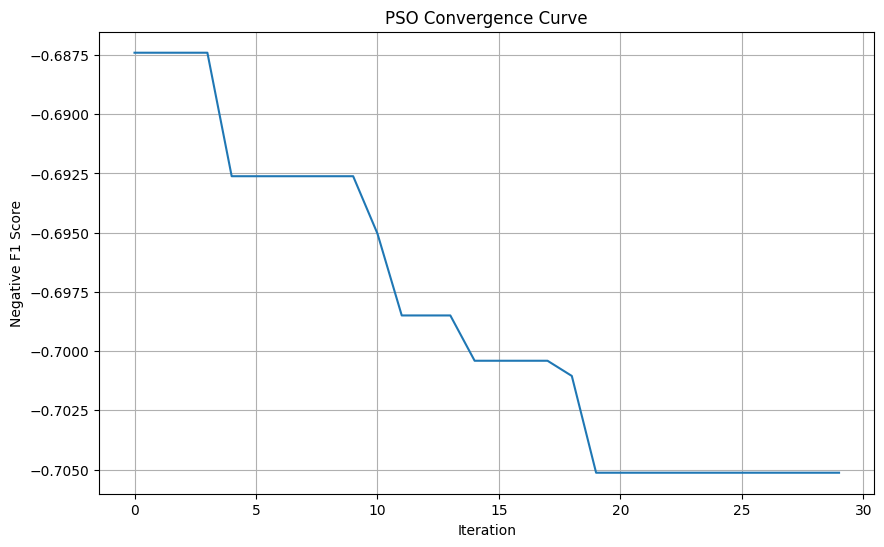

In [ ]:
# Plot convergence
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(optimizer.cost_history)
plt.title('PSO Convergence Curve')
plt.xlabel('Iteration')
plt.ylabel('Negative F1 Score')
plt.grid(True)
plt.show()